In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import matplotlib.pyplot as plt
from lab04lib import *

seed = np.random.seed

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))
#print(X_train_std)
#print(y_train)

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [-1  1]


In [2]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [3]:
# define the AdalineSGD class
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, mini_batch=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.mini_batch = mini_batch
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            batch_num = int(len(X) / self.mini_batch)
            for n in range(batch_num):
                x_batch = X[n*self.mini_batch:(n+1)*self.mini_batch]
                y_batch = y[n*self.mini_batch:(n+1)*self.mini_batch]
                cost.append(self._update_weights(x_batch, y_batch))
            avg_cost = sum(cost) / (self.mini_batch*batch_num)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, x_batch, y_batch):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(x_batch)
        
        # Cost function
        error = (y_batch - output)
        cost = 0.5 * (error**2).sum()
        
        # Update rule
        self.w_[1:] += self.eta * x_batch.T.dot(error)
        self.w_[0] += self.eta * error.sum()
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

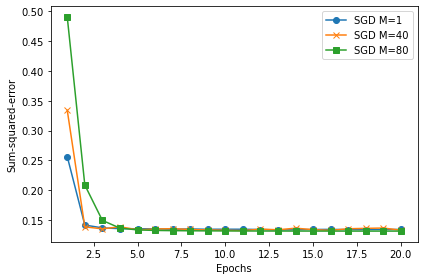

In [4]:
adas1 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, mini_batch=1)
adas1.fit(X_train_std, y_train)
adas2 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, mini_batch=40)
adas2.fit(X_train_std, y_train)
adas3 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, mini_batch=80)
adas3.fit(X_train_std, y_train)

plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_, 
         marker='o', label='SGD M=1')
plt.plot(range(1, len(adas2.cost_) + 1), np.array(adas2.cost_),
         marker='x', label='SGD M=40')
plt.plot(range(1, len(adas3.cost_) + 1), np.array(adas3.cost_),
         marker='s', label='SGD M=80')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/Lab04-1_109062562.png', dpi=300)
plt.show()

y_pred1 = adas1.predict(X_test_std)
y_pred2 = adas1.predict(X_test_std)
y_pred3 = adas1.predict(X_test_std)



M = 1, Misclassified samples: 3
M = 1, Accuracy: 0.85


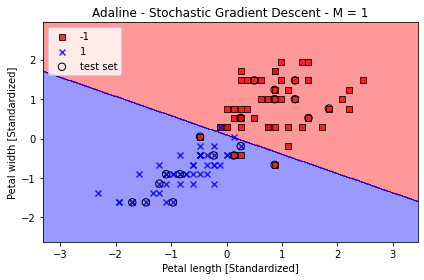

In [5]:
print('M = 1, Misclassified samples: %d' % (y_test != y_pred1).sum())
print('M = 1, Accuracy: %.2f' % accuracy_score(y_test, y_pred1))

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas1, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.title('Adaline - Stochastic Gradient Descent - M = 1')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-m=1-boundary.png', dpi=300)
plt.show()

M = 40, Misclassified samples: 3
M = 40, Accuracy: 0.85


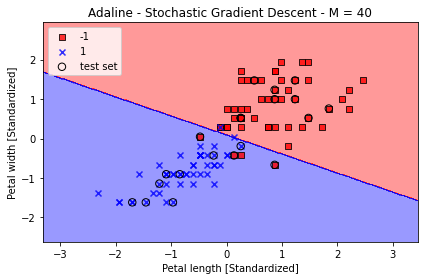

In [6]:
print('M = 40, Misclassified samples: %d' % (y_test != y_pred2).sum())
print('M = 40, Accuracy: %.2f' % accuracy_score(y_test, y_pred2))

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas2, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.title('Adaline - Stochastic Gradient Descent - M = 40')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-m=1-boundary.png', dpi=300)
plt.show()

M = 80, Misclassified samples: 3
M = 80, Accuracy: 0.85


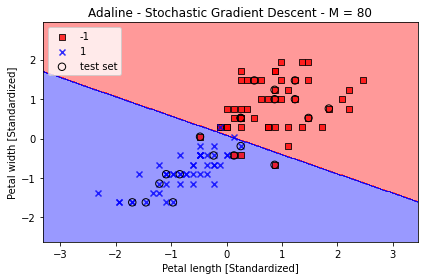

In [7]:
print('M = 80, Misclassified samples: %d' % (y_test != y_pred3).sum())
print('M = 80, Accuracy: %.2f' % accuracy_score(y_test, y_pred3))

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas3, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.title('Adaline - Stochastic Gradient Descent - M = 80')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-m=1-boundary.png', dpi=300)
plt.show()